# WENO coefficients

The starting point for a WENO code is a standard Lagrange interpolating polynomial.

Assume we're trying to reconstruct the function $q(x)$, and that we're given the cell-centred information $q_i = \langle q \rangle_i$ and the cells $I_i$ centred at $x_i$, where all the cells have width $\Delta x$. Then we want to use the stencil $I_{i-r+k+1}, \dots I_{i+k}$ which uses $r$ cells to construct the Lagrange interpolation polynomial of order $r$. This polynomial is sticks out the right by $k$ cells.

The Lagrange interpolation polynomial $p_{r, k}(x)$ is given by (equation (2.11) of Shu's review with notation and order altered)
$$
  p_{r, k}(x) = \sum_{m=0}^r \sum_{j=0}^{m-1} q_{i-r+k+1+j} \frac{1}{\Delta x^r} \frac{\sum_{l=0, l \ne m}^r \prod_{s=0, s \ne l, m}^r \left( x - x_{i-r+k+1+s+1/2} \right)}{\prod_{l=0, l \ne m}^r \left( m - l \right)}.
$$

When explicitly evaluated at $x_{i+1/2}$ we get (equation (2.19) of Shu's review, again altered to match Gerolymos et al)
$$
  p_{r, k, i+1/2} = \sum_{l=0}^{r-1} \left( \sum_{j=r-l}^r \frac{\sum_{m=0, m \ne j}^r \prod_{s=0, s \ne j, m}^r \left( r - k - s \right)}{\prod_{m=0, m \ne j}^r \left( j - m \right)} \right) q_{i+k-l} .
$$

Thus we write
$$
  q_{r, k, i+1/2} = \sum_{l=0}^{r-1} a_{r, k, l} q_{i+k-l}
$$
where the constants $a_{r, k, l}$ are given by
$$
  a_{r, k, l} = \sum_{j=r-l}^{r} \frac{\sum_{m=0, m \ne j}^r \prod_{s=0, s \ne j, m}^r \left( r - k - s \right)}{\prod_{m=0, m \ne j}^r \left( j - m \right)}.
$$

In [1]:
import sympy
sympy.init_printing()

In [2]:
def a_coefficient(order_r, shift_k, index_l):
    coefficient = sympy.Rational(0, 1)
    for j in range(order_r - index_l, order_r+1):
        numerator = 0
        denominator = 1
        for m in range(order_r+1):
            if m == j:
                pass
            else:
                product = 1
                for s in range(order_r+1):
                    if s == j or s == m:
                        pass
                    else:
                        product *= order_r - shift_k - s
                numerator += product
                denominator *= j - m
        coefficient += sympy.Rational(numerator, denominator)
    return coefficient

In [3]:
order_r = 3
for k in range(order_r):
    for l in range(order_r):
        print(k, l, a_coefficient(order_r, k, l))

0 0 11/6
0 1 -7/6
0 2 1/3
1 0 1/3
1 1 5/6
1 2 -1/6
2 0 -1/6
2 1 5/6
2 2 1/3


So an individual stencil, of order $r$, shifted by $k$, will have the form
$$
  q_{r, k, i+1/2} = \sum_{l=0}^{r-1} a_{r, k, l} q_{i+k-l}
$$
which we can show symbolically:

In [4]:
q = sympy.symbols(r'q:{}'.format(2*order_r-1))

In [5]:
def stencil(order_r, shift_k, q, offset=0):
    stencil_sum = sympy.Rational(0, 1)
    for l in range(order_r):
        stencil_sum += a_coefficient(order_r, shift_k, l) * q[order_r+shift_k-l-1-offset]
    return stencil_sum

In [6]:
for k in range(order_r):
    print(k, stencil(order_r, k, q))

0 q0/3 - 7*q1/6 + 11*q2/6
1 -q1/6 + 5*q2/6 + q3/3
2 q2/3 + 5*q3/6 - q4/6


We can, at the same time, compute the *single* stencil of order $2 r - 1$ that uses the same data as all of the stencils of order $r$, and compare the two:

In [7]:
print(stencil(2*order_r-1, order_r-1, q, offset=order_r-1))

q0/30 - 13*q1/60 + 47*q2/60 + 9*q3/20 - q4/20


Now, we can form a convex combination of each of the stencils of order $r$, so that 
$$
  q_{r, \text{Optimal}, i+1/2} = \sum_{k=0}^{r-1} C_{r, k} q_{r, k, i+1/2}.
$$
We can match the stencils and so compute the $C_{r, k}$ coefficients:

In [8]:
C = sympy.symbols(r'C:{}'.format(order_r))
sum_stencil = 0
for k in range(order_r):
    sum_stencil += C[k] * stencil(order_r, k, q)
eqns=[]
optimal_stencil = stencil(2*order_r-1, order_r-1, q, offset=order_r-1)
for k in range(order_r):
    eqns.append(sympy.Eq(optimal_stencil.expand().coeff(q[k]),
                         sum_stencil.expand().coeff(q[k])))
print(eqns)

[Eq(1/30, C0/3), Eq(-13/60, -7*C0/6 - C1/6), Eq(47/60, 11*C0/6 + 5*C1/6 + C2/3)]


In [9]:
sol=sympy.solve(eqns, C)
for k in range(order_r):
    print(k, sol[C[k]])

0 1/10
1 3/5
2 3/10


We convert that into a function:

In [10]:
def C_coefficients(order_r):
    coefficients = []
    q = sympy.symbols(r'q:{}'.format(2*order_r-1))
    C = sympy.symbols(r'C:{}'.format(order_r))
    sum_stencil = 0
    for k in range(order_r):
        sum_stencil += C[k] * stencil(order_r, k, q)
    eqns=[]
    optimal_stencil = stencil(2*order_r-1, order_r-1, q, offset=order_r-1)
    for k in range(order_r):
        eqns.append(sympy.Eq(optimal_stencil.expand().coeff(q[k]),
                             sum_stencil.expand().coeff(q[k])))
    solution = sympy.solve(eqns, C)
    for k in range(order_r):
        coefficients.append(solution[C[k]])
    return coefficients

In [11]:
check_r = 9
C = C_coefficients(check_r)
for k in range(check_r):
    print(C[k])

1/24310
36/12155
504/12155
2352/12155
882/2431
3528/12155
1176/12155
144/12155
9/24310


Now, using the optimal coefficients is ideal when the interpolating polynomial $p(x)$ is nice and smooth. When there are discontinuities it will give large oscillations. So we want some indication of when these oscillations will occur.

The Jiang-Shu smoothness indicators are given by the sum of the integrals of the square of the derivatives of the interpolating polynomial:
$$
  \beta_{r, k, i+1/2} = \sum_{m=1}^{r-1} \Delta x^{2 m -1} \int_{-\Delta x / 2}^{+\Delta x / 2} \text{d} (\xi - x_i) \, \frac{\text{d}^m}{\text{d} \xi^m} p_{r, k}(\xi-x_i).
$$
Using the square guarantees that it is positive. The factors of $\Delta x$ should cancel out once the definition of $p_{r, k}$ is included, so (without loss of generality) we set $\Delta x = 1$.

In [12]:
def interpolating_p(order_r, shift_k, xi_m_x, q):
    shift_r = order_r - shift_k - 1
    p = sympy.Rational(0, 1)
    for m in range(0, order_r+1):
        for j in range(0, m):
            numerator = 0
            denominator = 1
            for l in range(order_r+1):
                if l == m:
                    pass
                else:
                    product = 1
                    for s in range(order_r+1):
                        if s == l or s == m:
                            pass
                        else:
                            product *= xi_m_x + shift_r - s + sympy.Rational(1, 2)
                    numerator += product
                    denominator *= m - l
            p += q[order_r-shift_r+j-1] * numerator / denominator
    return p

In [13]:
def beta_integral(order_r, shift_k, q):
    xi_m_x = sympy.symbols(r'\xi')
    half = sympy.Rational(1, 2)
    sum_m = 0
    for m in range(1, order_r):
        sum_m += sympy.integrate(sympy.diff(interpolating_p(order_r, shift_k, xi_m_x, q).simplify(), xi_m_x, m)**2, 
                                 (xi_m_x, -half, half))
    return sum_m

In [14]:
for k in range(order_r):
    print(k, beta_integral(order_r, k, q).expand())

0 4*q0**2/3 - 19*q0*q1/3 + 11*q0*q2/3 + 25*q1**2/3 - 31*q1*q2/3 + 10*q2**2/3
1 4*q1**2/3 - 13*q1*q2/3 + 5*q1*q3/3 + 13*q2**2/3 - 13*q2*q3/3 + 4*q3**2/3
2 10*q2**2/3 - 31*q2*q3/3 + 11*q2*q4/3 + 25*q3**2/3 - 19*q3*q4/3 + 4*q4**2/3


In order to pre-calculate the smoothness indicators in a useful form, we want to match this against the expression that Gerolymos et al use, where the smoothness indicator is given as
$$
  \beta_{r, k, i+1/2} = \sum_{l=0}^{r-1} \sum_{m=0}^{l} \sigma_{r, k, l, m} q_{i+k-l} q_{i+k-m}.
$$

In [15]:
def beta_sigma(order_r, shift_k, q, sigma):
    sum_beta = 0
    for l in range(order_r):
        for m in range(l+1):
            sum_beta += sigma[l, m] * q[order_r+shift_k-l-1] * q[order_r+shift_k-m-1]
    return sum_beta.simplify()

In [16]:
sigma = sympy.MatrixSymbol('\sigma', order_r, order_r)
for k in range(order_r):
    print(k, beta_sigma(order_r, k, q, sigma))

0 q0**2*\sigma[2, 2] + q0*q1*\sigma[2, 1] + q0*q2*\sigma[2, 0] + q1**2*\sigma[1, 1] + q1*q2*\sigma[1, 0] + q2**2*\sigma[0, 0]
1 q1**2*\sigma[2, 2] + q1*q2*\sigma[2, 1] + q1*q3*\sigma[2, 0] + q2**2*\sigma[1, 1] + q2*q3*\sigma[1, 0] + q3**2*\sigma[0, 0]
2 q2**2*\sigma[2, 2] + q2*q3*\sigma[2, 1] + q2*q4*\sigma[2, 0] + q3**2*\sigma[1, 1] + q3*q4*\sigma[1, 0] + q4**2*\sigma[0, 0]


We can now read off the sigma coefficients:

In [17]:
def sigma_coefficients(order_r, shift_k):
    coefficients = []
    q = sympy.symbols(r'q:{}'.format(2*order_r-1))
    integral_beta = beta_integral(order_r, shift_k, q).expand()
    for l in range(order_r):
        l_coeffs = []
        for m in range(l+1):
            if l == m:
                l_coeffs.append(integral_beta.coeff(q[order_r+shift_k-l-1]**2))
            else:
                l_coeffs.append(integral_beta.coeff(q[order_r+shift_k-l-1]).coeff(q[order_r+shift_k-m-1]))
        coefficients.append(l_coeffs)
    return coefficients

In [18]:
for k in range(order_r):
    print(k, sigma_coefficients(order_r, k))

0 [[10/3], [-31/3, 25/3], [11/3, -19/3, 4/3]]
1 [[4/3], [-13/3, 13/3], [5/3, -13/3, 4/3]]
2 [[4/3], [-19/3, 25/3], [11/3, -31/3, 10/3]]


We can now do the higher order terms, which are all tabulated in Gerolymos et al:

In [19]:
order_r=4
print("a coefficients")
for k in range(order_r):
    for l in range(order_r):
        print(k, l, a_coefficient(order_r, k, l))
print("C coefficients")
C = C_coefficients(order_r)
for k in range(order_r):
    print(k, C[k])
print("sigma coefficients")
for k in range(order_r):
    print(k, sigma_coefficients(order_r, k))

a coefficients
0 0 25/12
0 1 -23/12
0 2 13/12
0 3 -1/4
1 0 1/4
1 1 13/12
1 2 -5/12
1 3 1/12
2 0 -1/12
2 1 7/12
2 2 7/12
2 3 -1/12
3 0 1/12
3 1 -5/12
3 2 13/12
3 3 1/4
C coefficients
0 1/35
1 12/35
2 18/35
3 4/35
sigma coefficients
0 [[2107/240], [-1567/40, 11003/240], [3521/120, -8623/120, 7043/240], [-309/40, 2321/120, -647/40, 547/240]]
1 [[547/240], [-1261/120, 3443/240], [961/120, -2983/120, 2843/240], [-247/120, 267/40, -821/120, 89/80]]
2 [[89/80], [-821/120, 2843/240], [267/40, -2983/120, 3443/240], [-247/120, 961/120, -1261/120, 547/240]]
3 [[547/240], [-647/40, 7043/240], [2321/120, -8623/120, 11003/240], [-309/40, 3521/120, -1567/40, 2107/240]]


We'll now write functions to generate a string representation of the coefficients:

In [22]:
import numpy

def print_a(order_r):
    a_numerators = []
    numers = []
    denoms = []
    lcms = []
    for k in range(order_r):
        k_numers = []
        k_denoms = []
        for l in range(order_r):
            coeff = a_coefficient(order_r, k, l)
            k_numers.append(sympy.numer(coeff))
            k_denoms.append(sympy.denom(coeff))
        numers.append(k_numers)
        denoms.append(k_denoms)
        lcms.append(sympy.lcm_list(k_denoms))
    lcm = sympy.lcm_list(lcms)
    for k in range(order_r):
        common_numers = []
        for l in range(order_r):
            common_numers.append(numers[k][l] * sympy.Rational(lcm, denoms[k][l]))
        a_numerators.append(common_numers)
    max_len = len(str(numpy.max(numpy.abs(numpy.array(a_numerators)))))
    string1 = "{{:>{}}}, ".format(max_len+1)
    string2 = "{{:>{}}}],\n".format(max_len+1)
    spacing_string = "     " + len(str(order_r))*" "
    a_string = "a_{} = numpy.array([\n".format(order_r)
    for k in range(order_r):
        a_string += spacing_string
        a_string += "             ["
        for l in range(order_r-1):
            a_string += string1.format(int(a_numerators[k][l]))
        a_string += string2.format(int(a_numerators[k][-1]))
    a_string += spacing_string
    a_string += "            ]) / {}".format(int(lcm))
    return a_string


def print_C(order_r):
    C_coeffs = C_coefficients(order_r)
    denoms = [sympy.denom(i) for i in C_coeffs]
    lcm = sympy.lcm_list(denoms)
    C_numerators = [sympy.numer(i) * sympy.Rational(lcm, sympy.denom(i)) for i in C_coeffs]
    max_len = len(str(numpy.max(numpy.abs(numpy.array(C_numerators)))))
    string1 = "{{:>{}}}, ".format(max_len+1)
    string2 = "{{:>{}}}".format(max_len+1)
    C_string = "C_{} = numpy.array([".format(order_r)
    for k in range(order_r-1):
        C_string += string1.format(int(C_numerators[k]))
    C_string += string2.format(int(C_numerators[-1]))
    C_string += " ]) / {}".format(int(lcm))
    return C_string


def print_sigma(order_r):
    sigma_numerators = []
    numers = []
    denoms = []
    lcms = []
    for k in range(order_r):
        k_numers = []
        k_denoms = []
        coeffs = sigma_coefficients(order_r, k)
        for l in range(order_r):
            l_numers = []
            l_denoms = []
            for m in range(l+1):
                l_numers.append(sympy.numer(coeffs[l][m]))
                l_denoms.append(sympy.denom(coeffs[l][m]))
            for m in range(l+1, order_r):
                l_numers.append(0)
                l_denoms.append(1)
            lcms.append(sympy.lcm_list(l_denoms))
            k_numers.append(l_numers)
            k_denoms.append(l_denoms)
        numers.append(k_numers)
        denoms.append(k_denoms)
    lcm = sympy.lcm_list(lcms)
    for k in range(order_r):
        k_common_numers = []
        for l in range(order_r):
            l_common_numers = []
            for m in range(order_r):
                l_common_numers.append(numers[k][l][m] * sympy.Rational(lcm, denoms[k][l][m]))
            k_common_numers.append(l_common_numers)
        sigma_numerators.append(k_common_numers)
    max_len = len(str(numpy.max(numpy.abs(numpy.array(sigma_numerators)))))
    string1 = "{{:>{}}}, ".format(max_len+1)
    string2 = "{{:>{}}}],".format(max_len+1)
    string3 = "{{:>{}}}]".format(max_len+1)
    string4 = "{{:>{}}}] ]\n".format(max_len+1)
    spacing_string = "     " + len(str(order_r))*" "
    sigma_string = "sigma_{} = numpy.array([".format(order_r)
    start_k_string = "\n" + spacing_string + "                  ["
    start_l_string = "\n" + spacing_string + "                    ["
    end_k_string   = "\n" + spacing_string + "                  ],"
    end_l_string   = "\n" + spacing_string + "                    ],"
    for k in range(order_r-1):
        sigma_string += start_k_string
        for l in range(order_r-1):
            sigma_string += start_l_string
            for m in range(order_r-1):
                sigma_string += string1.format(int(sigma_numerators[k][l][m]))
            sigma_string += string2.format(int(sigma_numerators[k][l][-1]))
        sigma_string += start_l_string
        for m in range(order_r-1):
            sigma_string += string1.format(int(sigma_numerators[k][-1][m]))
        sigma_string += string3.format(int(sigma_numerators[k][-1][-1]))
        sigma_string += end_k_string
    sigma_string += start_k_string
    for l in range(order_r-1):
        sigma_string += start_l_string
        for m in range(order_r-1):
            sigma_string += string1.format(int(sigma_numerators[-1][l][m]))
        sigma_string += string2.format(int(sigma_numerators[-1][l][-1]))
    sigma_string += start_l_string
    for m in range(order_r-1):
        sigma_string += string1.format(int(sigma_numerators[-1][-1][m]))
    sigma_string += string3.format(int(sigma_numerators[-1][-1][-1]))
    sigma_string += "\n" + spacing_string + "                  ]" + "\n"
    if lcm == 1:
        sigma_string += "                      ])"
    else:
        sigma_string += "                      ]) / {}".format(int(lcm))
    return sigma_string

In [21]:
# You really don't want to do this - it's only there to
# check that the output from the functions is executable
# Python code

#exec(print_sigma(4))
#sigma_4

From the string representations we can create a "human readable" (hmm...) Python file that could be used with the WENO reconstruction routines in eg `pyro`.

In [23]:
# Output the first "few" sets of coefficients to a file
# This takes around 5 minutes on my machine...

order_lo = 2
order_hi = 7

with open('./weno_coefficients.py', 'tw') as f:
    f.write("import numpy\n")
    f.write("\n\n")
    for order in range(order_lo, order_hi+1):
        f.write("# Coefficients of order r={}\n".format(order))
        f.write("# On smooth solutions this should converge with order r={}\n".format(2*order-1))
        f.write(print_C(order))
        f.write("\n")
        f.write(print_a(order))
        f.write("\n")
        f.write(print_sigma(order))
        f.write("\n\n")
    for var in "C", "a", "sigma":
        f.write(var + "_all = {\n")
        for order in range(order_lo, order_hi):
            f.write((len(var)+9)*" " + "{0} : {1}_{0},\n".format(order, var))
        f.write((len(var)+9)*" " + "{0} : {1}_{0}\n".format(order_hi, var))
        f.write((len(var)+7)*" " + "}\n\n")

Now we can use the coefficients, and repeat the convergence plot from the figures file.

In [24]:
import weno_coefficients

In [72]:
def weno(order, q):
    """
    Do WENO reconstruction
    
    Parameters
    ----------
    
    order : int
        The stencil width
    q : numpy array
        Scalar data to reconstruct
        
    Returns
    -------
    
    qL : numpy array
        Reconstructed data - boundary points are zero
    """
    C = weno_coefficients.C_all[order]
    a = weno_coefficients.a_all[order]
    sigma = weno_coefficients.sigma_all[order]

    qL = numpy.zeros_like(q)
    beta = numpy.zeros((order, len(q)))
    w = numpy.zeros_like(beta)
    np = len(q) - 2 * order
    epsilon = 1e-16
    for i in range(order, np+order):
        q_stencils = numpy.zeros(order)
        alpha = numpy.zeros(order)
        for k in range(order):
            for l in range(order):
                for m in range(l+1):
                    beta[k, i] += sigma[k, l, m] * q[i+k-l] * q[i+k-m]
            alpha[k] = C[k] / (epsilon + beta[k, i]**2)
            for l in range(order):
                q_stencils[k] += a[k, l] * q[i+k-l]
        w[:, i] = alpha / numpy.sum(alpha)
        qL[i] = numpy.dot(w[:, i], q_stencils)
    
    return qL

We use a smooth $\sin$ function as the exact solution. The smaples to be reconstructed are the cell integral averages which, of course, come from a $\cos$ function appropriately evaluated at the cell edges.

In [82]:
f_smooth = lambda x: numpy.sin(2 * numpy.pi * x)
f_antiderivative = lambda x: -numpy.cos(2 * numpy.pi * x) / (2 * numpy.pi)

# Convergence check, using the lazy fix to get error norms.
orders = numpy.arange(min(weno_coefficients.C_all.keys()), max(weno_coefficients.C_all.keys())+1)
points = 4 * 2**numpy.arange(1, 7)
error_1norm = numpy.zeros((len(points), len(orders)))
error_2norm = numpy.zeros((len(points), len(orders)))
for i, pts in enumerate(points):
    dx = 1 / pts
    x_recon_interior = numpy.arange(dx/2, 1, dx)
    recon_exact = f_smooth(x_recon_interior + dx/2)
    for j, order in enumerate(orders):
        x_recon = numpy.arange(dx * (1/2 - order), 1 + dx * order, dx)
        s_recon = (f_antiderivative(x_recon + dx/2) -
                   f_antiderivative(x_recon - dx/2)) / dx
        s_weno = weno(order, s_recon)
        error_1norm[i, j] = numpy.linalg.norm(s_weno[order:-order] - recon_exact, 1) / pts
        error_2norm[i, j] = numpy.linalg.norm(s_weno[order:-order] - recon_exact, 2) / numpy.sqrt(pts)

In [79]:
%matplotlib inline
from matplotlib import pyplot

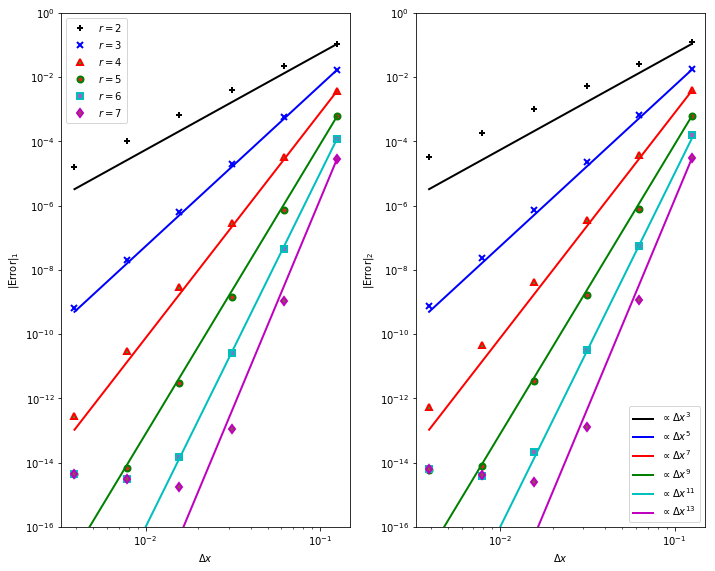

In [87]:
dxs = 1 / points
fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 8))
markers = '+x^osd<'
colours = 'kbrgcm'
for i, order in enumerate(orders):
    axes[0].loglog(dxs, error_1norm[:, i], label=r"$r={}$".format(order),
                   linestyle=None, linewidth=0,
                   marker=markers[i], mec=colours[i], markersize=6, mew=2)
    axes[0].loglog(dxs, error_1norm[0, i] * (dxs/dxs[0])**(2*order-1),
                   linewidth=2, color=colours[i])
    axes[1].loglog(dxs, error_2norm[:, i], 
                   linestyle=None, linewidth=0,
                   marker=markers[i], mec=colours[i], markersize=6, mew=2)
    axes[1].loglog(dxs, error_1norm[0, i] * (dxs/dxs[0])**(2*order-1),
                   linewidth=2, color=colours[i],
                   label=r"$\propto \Delta x^{{{}}}$".format(2*order-1))
axes[0].set_xlabel(r"$\Delta x$")
axes[1].set_xlabel(r"$\Delta x$")
axes[0].set_ylabel(r"$|$Error$|_1$")
axes[1].set_ylabel(r"$|$Error$|_2$")
axes[0].set_ylim(1e-16, 1)
axes[1].set_ylim(1e-16, 1)
axes[0].legend()
axes[1].legend()
fig.tight_layout()

Note here that floating point error kicks in very quickly for the high order schemes. Equally for the lowest order scheme we probably need higher resolution to get clean convergence.